# Recsys'20 Feature Engineering Tutorial Part 2
> RecSys'20 tutorial on feature engineering on a large retail dataset part 2

- toc: true
- badges: true
- comments: true
- categories: [features, recsys, cudf, retail, bigdata]
- image: 

### Install RAPIDS

In [ ]:
# Check Python Version
!python --version

# Check Ubuntu Version
!lsb_release -a

# Check CUDA/cuDNN Version
!nvcc -V && which nvcc

# Check GPU
!nvidia-smi

Python 3.7.10
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
/usr/local/cuda/bin/nvcc
Sat Jun 19 07:09:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 272 (delta 56), reused 38 (delta 19), pack-reused 171
Receiving objects: 100% (272/272), 79.66 KiB | 1.35 MiB/s, done.
Resolving deltas: 100% (118/118), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [599 kB]
Hi

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL, 
!python rapidsai-csp-utils/colab/install_rapids.py stable

Installing RAPIDS Stable 21.06
Starting the RAPIDS+BlazingSQL install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.0
    - gcsfs
    - llvmlite
    - openssl
    - python=3.7
    - rapids-blazing=21.06


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20210324.1      |       h9c3ff4c_0        1015 KB  conda-forge
    aiohttp-3.7.4.post0        |   py37h5e8e339_0         625 KB  conda-forge
    anyio-3.2.0                |   py37h89c1867_0         138 KB  conda-forge
    appdirs-1.4.4              |     pyh9f0ad1d_0      

In [1]:
import IPython

import pandas as pd
import cudf
import numpy as np
import cupy
import matplotlib.pyplot as plt

### Data load

In [ ]:
!cp /content/drive/MyDrive/Recommendation/data_silver_l2.zip /content
!unzip /content/data_silver_l2.zip

Archive:  /content/data_silver_l2.zip
  inflating: test.parquet            
  inflating: train.parquet           
  inflating: valid.parquet           


In [2]:
df_train = cudf.read_parquet('/content/train.parquet')
df_valid = cudf.read_parquet('/content/valid.parquet')
df_test = cudf.read_parquet('/content/test.parquet')

df_train.isna().sum()

event_time             0
event_type             0
product_id             0
category_code    1527738
brand             949133
price                  0
user_id                0
user_session          66
target                 0
timestamp              0
ts_hour                0
ts_minute              0
ts_weekday             0
ts_day                 0
ts_month               0
ts_year                0
dtype: uint64

In [3]:
_temp = df_train['category_code'].str.split(".", n=3, expand=True).fillna('NA')
_temp.columns = ['cat_{}'.format(x) for x in _temp.columns]
df_train.drop('category_code', axis=1, inplace=True)
df_train = df_train.join(_temp)

_temp = df_valid['category_code'].str.split(".", n=3, expand=True).fillna('NA')
_temp.columns = ['cat_{}'.format(x) for x in _temp.columns]
df_valid.drop('category_code', axis=1, inplace=True)
df_valid = df_valid.join(_temp)

_temp = df_test['category_code'].str.split(".", n=3, expand=True).fillna('NA')
_temp.columns = ['cat_{}'.format(x) for x in _temp.columns]
df_test.drop('category_code', axis=1, inplace=True)
df_test = df_test.join(_temp)

In [ ]:
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,cat_0,cat_1,cat_2,cat_3
15328,2020-01-23 10:22:27 UTC,cart,1005101,xiaomi,419.31,602604607,ec725848-03db-4a0d-94b2-d0121f79dbb5,0,2020-01-23 10:22:27,10,22,3,23,1,2020,construction,tools,light,NA
15329,2020-01-23 10:22:27 UTC,cart,17300751,versace,81.57,543745697,860e30ab-c461-40ef-aa17-1f74acc94f21,0,2020-01-23 10:22:27,10,22,3,23,1,2020,apparel,shoes,sandals,NA
15330,2020-01-23 10:22:37 UTC,cart,4802273,samsung,6.67,512756088,0b8d5157-50ee-46ae-9772-e599004d1cbc,0,2020-01-23 10:22:37,10,22,3,23,1,2020,sport,bicycle,NA,NA
15331,2020-01-23 10:22:38 UTC,cart,2900561,midea,48.86,571387327,2366dffb-a199-4aa1-b6a3-12fe807ea80d,0,2020-01-23 10:22:38,10,22,3,23,1,2020,furniture,bedroom,blanket,NA
15332,2020-01-23 10:22:40 UTC,cart,17501003,enough,6.69,590902280,38efa242-cba4-45ac-8d28-a96d964d0e57,0,2020-01-23 10:22:40,10,22,3,23,1,2020,apparel,costume,NA,NA


### Missing value imputation

Categorical Features: Imputing categorical features is easy - a unique category value (e.g. "UNKNOWN") can be imputed

Important: Before imputing the missing values, it is beneficial to create a indicator column, which indicate if the a value was imputed or not. There is maybe a underlying pattern for the missing values and models can learn the pattern.

In [ ]:
cols = ['brand', 'user_session', 'cat_0', 'cat_1', 'cat_2', 'cat_3']

for col in cols:
    df_train['NA_' + col] = df_train[col].isna().astype(np.int8)
    df_train[col].fillna('UNKNOWN', inplace=True)

In [ ]:
df_train.isna().sum()

event_time         0
event_type         0
product_id         0
brand              0
price              0
user_id            0
user_session       0
target             0
timestamp          0
ts_hour            0
ts_minute          0
ts_weekday         0
ts_day             0
ts_month           0
ts_year            0
cat_0              0
cat_1              0
cat_2              0
cat_3              0
NA_brand           0
NA_user_session    0
NA_cat_0           0
NA_cat_1           0
NA_cat_2           0
NA_cat_3           0
dtype: uint64

Numerical Features: Imputing median for the numerical value (per group)
Imputing mean for numercial value (per group)
In some cases, we may know what value should be used as the default value (e.g. 0 for historical data or the max)


Important: For the same reason as in the categorical case, it is important to add a indicator column that the datapoint was imputed.

In our case, we do not have missing values in the numerical column price. Therefore, we artificially inject nans and then compare the difference.

In [ ]:
np.random.seed(42)
df_train.loc[np.random.random(df_train.shape[0])<0.01, 'price'] = None
df_train['price'].isna().mean()

0.009994654311413111

We calculate the median per cat_2 and merge it to the dataset.

In [ ]:
df_median = df_train[['cat_2', 'price']].groupby('cat_2').median().reset_index()
df_median.columns = ['cat_2', 'price_median_per_cat2']
df_train = df_train.merge(df_median, how='left', on='cat_2')

We create an indicator column, when price was not available and then overwrite the missing values with the median.

In [ ]:
df_train['NA_price'] = df_train[col].isna().astype(np.int8)
df_train.loc[df_train['price'].isna(), 'price'] = df_train.loc[df_train['price'].isna(), 'price_median_per_cat2']
df_train.drop('price_median_per_cat2', axis=1, inplace=True)
df_train.head(5)

,event_time,event_type,product_id,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,cat_0,cat_1,cat_2,cat_3,NA_brand,NA_user_session,NA_cat_0,NA_cat_1,NA_cat_2,NA_cat_3,NA_price
0,2020-01-23 13:55:58 UTC,cart,1002524,apple,514.81,568965448,ed183a73-dbce-4f24-893c-fcf8541ec69a,0,2020-01-23 13:55:58,13,55,3,23,1,2020,construction,tools,light,NA,0,0,0,0,0,0,0
1,2020-01-23 13:55:59 UTC,cart,1005099,samsung,141.05,603972321,5bf2241f-6062-4403-9fd5-b746e43149e2,0,2020-01-23 13:55:59,13,55,3,23,1,2020,construction,tools,light,NA,0,0,0,0,0,0,0
2,2020-01-23 13:55:59 UTC,cart,1002524,apple,514.81,568965448,ed183a73-dbce-4f24-893c-fcf8541ec69a,0,2020-01-23 13:55:59,13,55,3,23,1,2020,construction,tools,light,NA,0,0,0,0,0,0,0
3,2020-01-23 13:55:59 UTC,cart,1002524,apple,514.81,568965448,ed183a73-dbce-4f24-893c-fcf8541ec69a,0,2020-01-23 13:55:59,13,55,3,23,1,2020,construction,tools,light,NA,0,0,0,0,0,0,0
4,2020-01-23 13:55:59 UTC,cart,26010323,UNKNOWN,9.01,530857374,26b6aa26-d125-4cb4-9249-f74053b0b950,0,2020-01-23 13:55:59,13,55,3,23,1,2020,NA,NA,NA,NA,1,0,0,0,0,0,0


In [ ]:
df_train['price'].isna().mean()

0.0

Predicting missing values: In [Improving Deep Learning For Airbnb Search](https://arxiv.org/abs/2002.05515), the authors propose to use a DNN for missing user engagement features of new items (listenings). New items have no historical user engagements, such as # of views, # of bookings, etc.. In the paper, they train a DNN based on the meta information, such as price, location and predict the user engagements feature. This could be interpreted in what are the expected user engagement.

Instead of the hand-crafted default values for missing user engagement, the authors replaced the missing values with the prediction of the DNN and showed that it reduced the error by 43% (offline test) and improved the overall bookings by 0.38% (online A/B test).

### Feature cross - basics

*Combining Categories (CC)* is a simple, powerful technique, but often undervalued. We will use this strategy in other feature engineering techniques, as well, and will introduce its value in a simple example.

In some datasets, categories by itself provide no information to predict the target. But if we combine multiple categories, together, then we can indentify patterns.

For example, we have the following categories:
- Weekday
- Hour of the day

Each of them independently has no significant pattern in the dataset. If we combine them with Weekday_HourOfTheDay, then we can observe some strong behavior for certainn times on the weekend

Decision Trees determine the split in the dataset on single features. If each categorical feature by itself does not provide the information gain, then Decision Trees cannot find a good split. If we provide a combined categorical feature, the Decision Tree can easier split the dataset.

Combining categories, also called Cross Column or Cross Product, is used in the Wide Deep Architecture by Google and is implemented in Tensorflow.

In [ ]:
f1 = [0]*45 + [1]*45 + [2]*10 + [0]*5 + [1]*5 + [2]*90 + [0]*5 + [1]*5 + [2]*90 + [0]*45 + [1]*45 + [2]*10
f2 = [0]*45 + [0]*45 + [0]*10 + [1]*5 + [1]*5 + [1]*90 + [0]*5 + [0]*5 + [0]*90 + [1]*45 + [1]*45 + [1]*10
t = [1]*45 + [1]*45 + [1]*10 + [1]*5 + [1]*5 + [1]*90 + [0]*5 + [0]*5 + [0]*90 + [0]*45 + [0]*45 + [0]*10

data = cudf.DataFrame({
    'f1': f1,
    'f2': f2,
})

for i in range(3,5):
    data['f' + str(i)] = np.random.choice(list(range(3)), data.shape[0])

data['target'] = t

In [ ]:
data.head()

,f1,f2,f3,f4,target
0,0,0,2,2,1
1,0,0,2,1,1
2,0,0,0,2,1
3,0,0,2,2,1
4,0,0,2,1,1


We take a look on the features f1 and f2. Each of the feature provides no information gain as each category has a 0.5 probability for the target.

In [ ]:
data.groupby('f1').target.agg(['mean', 'count'])

,mean,count
f1,,
1,0.5,100
0,0.5,100
2,0.5,200


In [ ]:
data.groupby('f2').target.agg(['mean', 'count'])

,mean,count
f2,,
1,0.5,200
0,0.5,200


If we analyze the features f1 and f2 together, we can observe a significant pattern in the target variable.

In [ ]:
data.groupby(['f1', 'f2']).target.agg(['mean', 'count'])

mean  count
f1 f2             
0  0    0.9     50
1  1    0.1     50
   0    0.9     50
2  1    0.9    100
   0    0.1    100
0  1    0.1     50

Next, we train a simple Decision Tree to show how combining categories will support the decision boundaries.

In [ ]:
df = data.to_pandas()

In [ ]:
import pydotplus
import sklearn.tree as tree
from IPython.display import Image

In [ ]:
def get_hotn_features(df):
    out = []
    for col in df.columns:
        if col != 'target':
            out.append(pd.get_dummies(df[col], prefix=col))
    return(pd.concat(out, axis=1))

def viz_tree(df, lf):
    dt_feature_names = list(get_hotn_features(df).columns)
    dt_target_names = 'target'
    tree.export_graphviz(lf, out_file='tree.dot', 
                         feature_names=dt_feature_names, class_names=dt_target_names,
                         filled=True)  
    graph = pydotplus.graph_from_dot_file('tree.dot')
    return(graph.create_png())

First, we train it without the combined categories f1 and f2. We can see, that the Decision Trees creates the split on the random features f3 and f4. The leaves have only a small information gain (e.g. 98 negative vs. 82 positive).

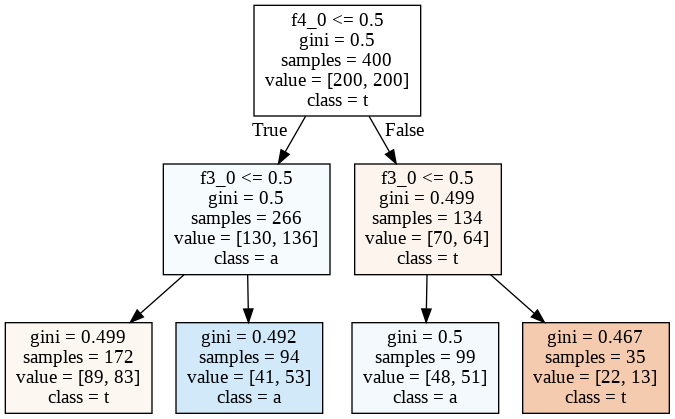

In [ ]:
lf = tree.DecisionTreeClassifier(max_depth=2)
lf.fit(get_hotn_features(df), df[['target']])
Image(viz_tree(df, lf))

Now, we combine the categories f1 and f2 as an additional feature. We can see that the Decision Tree uses that feature first and that the splits have a high information gain. For example, 190 negative vs. 110 positives.

In [ ]:
df['f1_f2'] = df['f1'].astype(str) + df['f2'].astype(str)

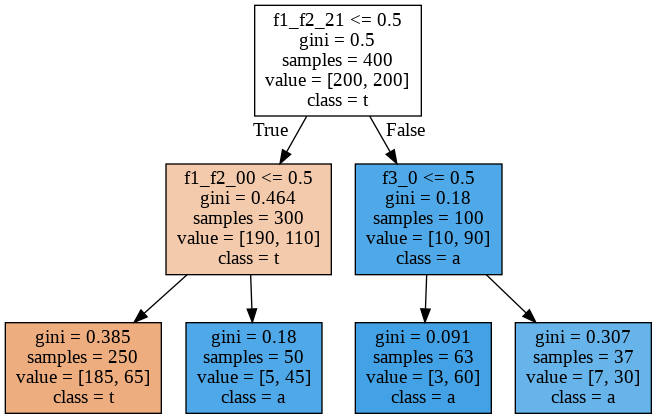

In [ ]:
lf.fit(get_hotn_features(df), df[['target']])
Image(viz_tree(df, lf))

This simple technique will be used in combination with other feature engineering techniques.

We may have the idea - that is great, let's combine all categories into one feature. Unfortunately, this is not that easy. We want to balance the number of categories used, the number of observations in resulting category values and the information gain:

The more categories we combine, we will identify more underlying patterns - but combining more categories together reduces the number of observation per categoy in the resulting features
Higher number of observation in the resulting category shows a strong pattern and it is more generalizable
High information gain supports our model, but only if it is generalizable
The extreme example is that we combine all features f1, f2, f3 and f4 together. But the observation per category (count) is very small (4-20)

In [ ]:
df.groupby([x for x in df.columns if 'target' not in x and 'f1_f2' not in x]).target.agg(['mean', 'count']).head(10)

mean  count
f1 f2 f3 f4                 
0  0  0  0   1.000000      4
         1   1.000000      6
         2   1.000000      5
      1  0   0.857143      7
         1   1.000000      5
         2   1.000000      8
      2  0   0.666667      3
         1   1.000000      5
         2   0.571429      7
   1  0  0   0.000000      4

Best practices:

- Combining low cardinal categories is a good start. For example, the dataset size is 100M rows and there are multiple categories with a caridnality (# of unique values) of 10-50, then combining them should not result in low observation count
- Exploratory Data Analysis (EDA) is faster than training a model. Analyzing the information value for different combination of categorical features (on a sample) is really fast.

In [ ]:
# Example of getting the cardinality for categories:
df.astype(str).describe()

,f1,f2,f3,f4,target,f1_f2
count,400,400,400,400,400,400
unique,3,2,3,3,2,6
top,2,1,1,1,1,21
freq,200,200,137,136,200,100


### Apply feature cross

In [ ]:
def explore_cat(df, cats):
    df_agg = df_train[cats + ['target']].groupby(cats).agg(['mean', 'count']).reset_index()
    df_agg.columns = cats + ['mean', 'count']
    print(df_agg.sort_values('count', ascending=False).head(20))
    
cats = ['product_id', 'user_id']  
explore_cat(df_train, cats)

         product_id    user_id      mean  count
553991      1004767  545442548  0.000000    807
2757949     1004767  525325337  0.000000    753
832745      1005107  553431815  0.598372    737
2887447    15300303  512875426  0.000000    709
4631256     1005174  563599039  0.929412    510
2162303     1004873  515032042  0.002041    490
2890567     4804718  536911254  0.000000    471
5949107     8800045  557590749  0.000000    380
5436668     1002524  515598234  0.581522    368
759242      3601537  578263741  0.000000    363
2090692     1004833  564068124  0.791667    360
5431410     1005115  516010934  0.616046    349
5744834     1005100  611998200  0.000000    333
5843134     1004249  513901034  0.648562    313
5548274     1005008  521558076  0.003236    309
1026458     1005161  512924342  0.535354    297
640836      4804718  576154686  0.548611    288
6111734   100007950  515481166  0.000000    287
2510850     3601489  513824664  0.000000    275
119345      1002544  545376441  0.896296

In [ ]:
cats = ['ts_weekday', 'ts_hour']  
explore_cat(df_train, cats)

     ts_weekday  ts_hour      mean   count
101           4        9  0.302715  136237
18            4        8  0.305953  134661
155           4       10  0.302520  131525
51            4        7  0.298787  128148
104           5        7  0.315947  126382
118           4        6  0.282097  126070
43            4       11  0.293566  126026
55            5        8  0.359090  125818
110           5        9  0.414171  123601
145           6       10  0.412849  123343
106           6        8  0.411147  122776
156           6        7  0.412360  121891
98            5       10  0.402228  121344
127           6        9  0.407846  121183
152           6       11  0.429601  120726
126           5        6  0.315390  120679
135           4        5  0.279342  118364
8             5       11  0.346054  117187
11            6        6  0.411512  115909
47            6       12  0.423719  113927


In [ ]:
cats = ['cat_2', 'brand']  
explore_cat(df_train, cats)

                cat_2     brand      mean    count
141             light   samsung  0.478160  1216099
9278            light     apple  0.465644  1018787
5421               NA     apple  0.377829   883712
471                NA   samsung  0.400737   717738
4594               NA   UNKNOWN  0.275269   522929
192             light    xiaomi  0.393963   512147
3416               NA    xiaomi  0.288319   484502
8098            light    huawei  0.457535   229552
8266        headphone     apple  0.327196   121447
3730               NA    huawei  0.377412   117524
1929               NA  cordiant  0.245952   110062
2079               NA      sony  0.359959   109354
8914            light      oppo  0.501943    99097
1602         massager   samsung  0.403950    85726
10974          vacuum   samsung  0.388883    68545
10844          washer   samsung  0.331476    59416
2793   coffee_grinder   lucente  0.508868    58469
5568    refrigerators   samsung  0.446318    57636
9342               NA      oppo

Hypothesis:
- Some user will always buy the same one-way products e.g. cleaning supplies, food
- Behavior changes on weekday+hour - e.g. during the week, users will not stay up late as they work next day
- Category and brand are both powerful features, but the combination can be more important. E.g. do people buy apple smartphones or accessories?

### Categorify

*Categorifying* is required for using categorical features in deep learning models with Embedding layers. An Embedding layer encodes the category into a hidden latent vector with a smaller dimension.

Categorical features can be from datatype String or Integer. The Embedding layer requires that categorical features are continoues, positive Integers from 0 to |C| (number of unique category values).

In [ ]:
df_train['product_id'].unique()

0           1000894
1           1000978
2           1001588
3           1001605
4           1001606
            ...    
164448    100143856
164449    100143867
164450    100144046
164451    100144443
164452    100144608
Name: product_id, Length: 164453, dtype: int64

In [ ]:
# Using factorize creates continous integers from a categorical feature
codes, uniques = df_train['product_id'].factorize()
codes

array([   24,  1033,    24, ..., 37414,   776, 18803], dtype=int32)

In [ ]:
uniques

Int64Index([  1000894,   1000978,   1001588,   1001605,   1001606,   1001618,
              1001619,   1001820,   1002042,   1002062,
            ...
            100143480, 100143510, 100143590, 100143628, 100143638, 100143856,
            100143867, 100144046, 100144443, 100144608],
           dtype='int64', length=164453)

Another important reason to Categorify categorical features is to reduce the size of the dataset. Often categorical features are of the datatype String and sometimes, they are hashed to protect the user / dataset privacy.

In [ ]:
import hashlib
from sys import getsizeof

For example, we can hash the Integer 0 to a md5 hash

In [ ]:
hashlib.md5(b'0').hexdigest()

'cfcd208495d565ef66e7dff9f98764da'

We can hash the full product_id column

In [ ]:
hashSeries = df_train['product_id'].to_pandas().apply(lambda x: hashlib.md5(bytes(str(x), encoding='utf-8')).hexdigest())
hashSeries

0           869aaba3c9113c27539bb1c3232e651c
1           a545dff4990390c31fa997325f45f697
2           869aaba3c9113c27539bb1c3232e651c
3           869aaba3c9113c27539bb1c3232e651c
4           eaefcc8eeaf8ee99768f5bd0e4ded9b9
                          ...               
11495240    6c05e1b9e466725f725df0326a1b5039
11495241    8ce7e84738eb6f686d418101d520df2e
11495242    cedc44508ef5c516bc445fe2944c4b91
11495243    6b327527a0cf16326f9dd2bf455c3056
11495244    032bab49d0c08d80d8ff08f826078dd4
Name: product_id, Length: 11495245, dtype: object

In [ ]:
codes, uniques = hashSeries.factorize()

In [ ]:
print("product id column size is reduced from {} to {}. We need only {:.2f}% of the original DataSeries memory."\
      .format(getsizeof(hashSeries), getsizeof(pd.DataFrame(codes)[0]),
              getsizeof(hashSeries)/getsizeof(pd.DataFrame(codes)[0])))

product id column size is reduced from 1023076965 to 91962120. We need only 11.12% of the original DataSeries memory.


Finally, we can prevent overfitting for low frequency categories. Categories with low frequency can be grouped together to an new category called 'other'. In the previous exercise we learned that it is powerful to combine categorical features together to create a new feature. However, combining categories increases the cardinality of the new feature and the number of observations per category will decrease. Therefore, we can apply a treshhold to group all categories with lower frequency count to the the new category.

In addition, categories, which occurs in the validation dataset and do not occur in the training dataset, should be mapped to the 'other' category as well.

We use in our example the category Ids 0 or 1 for a placeholder for the low frequency and unkown category. Then our function is independent of the cardinality of the categorical feature and we do not keep records of the cardinality to know the low frequency/unkown category.

In our dataset, we see that multiple product_ids occur only once in the training dataset. Our model would overfit to these low frequency categories.

In [ ]:
cat = 'product_id'

In [ ]:
freq = df_train[cat].value_counts()
freq = freq.reset_index()
freq.columns = [cat, 'count']
freq = freq.reset_index()
freq.columns = [cat + '_Categorify', cat, 'count']
freq_filtered = freq[freq['count']>5]
freq_filtered[cat + '_Categorify'] = freq_filtered[cat + '_Categorify']+1
freq_filtered = freq_filtered.drop('count', axis=1)

In [ ]:
freq_filtered.head()

,product_id_Categorify,product_id
0,1,1004767
1,2,1005115
2,3,1004856
3,4,4804056
4,5,1005100


In [ ]:
freq_filtered.shape

(76500, 2)

In [ ]:
df_train = df_train.merge(freq_filtered, how='left', on=cat) #giving memory error
df_train[cat + '_Categorify'] = df_train[cat + '_Categorify'].fillna(0)
df_train['product_id_Categorify'].min(), df_train['product_id_Categorify'].max(), df_train['product_id_Categorify'].drop_duplicates().shape

We need to apply the categorify to our validation and test sets.

In [ ]:
df_valid = df_valid.merge(freq_filtered, how='left', on=cat)
df_valid[cat + '_Categorify'] = df_valid[cat + '_Categorify'].fillna(0)

df_test = df_test.merge(freq_filtered, how='left', on=cat)
df_test[cat + '_Categorify'] = df_test[cat + '_Categorify'].fillna(0)

- Categorify is important to enable deep learning models to use categorical features
- Categorify can significantly reduce the dataset size by tranforming categorical features from String datatypes to Integer datatypes
- Categorify can prevent overfitting by grouping categories with low frequency into one category together

Categorify the category features brand, Apply a frequency treshhold of minimum 20, Map low frequency categories to the id=0, and Map unkown categories to the id=1 in the validation and test set

In [ ]:
cat = 'brand'

freq = df_train[cat].value_counts()
freq = freq.reset_index()
freq.columns = [cat, 'count']
freq = freq.reset_index()
freq.columns = [cat + '_Categorify', cat, 'count']
freq[cat + '_Categorify'] = freq[cat + '_Categorify']+2
freq.loc[freq['count']<20, cat + '_Categorify'] = 0

freq = freq.drop('count', axis=1)

# df_train = df_train.merge(freq, how='left', on=cat)
# df_train[cat + '_Categorify'] = df_train[cat + '_Categorify'].fillna(1)

df_valid = df_valid.merge(freq, how='left', on=cat)
df_valid[cat + '_Categorify'] = df_valid[cat + '_Categorify'].fillna(1)

df_test = df_test.merge(freq, how='left', on=cat)
df_test[cat + '_Categorify'] = df_test[cat + '_Categorify'].fillna(1)

In [ ]:
df_test.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,cat_0,cat_1,cat_2,cat_3,product_id_Categorify,brand_Categorify
0,2020-04-09 16:47:18 UTC,cart,1005100,samsung,144.89,604644674,16b2649b-56d9-47e8-afe9-c16d97af142b,0,2020-04-09 16:47:18,16,47,3,9,4,2020,construction,tools,light,NA,5,2
1,2020-04-09 16:47:18 UTC,cart,1005100,samsung,144.89,604644674,16b2649b-56d9-47e8-afe9-c16d97af142b,0,2020-04-09 16:47:18,16,47,3,9,4,2020,construction,tools,light,NA,5,2
2,2020-04-09 16:47:18 UTC,cart,1005100,samsung,144.89,604644674,16b2649b-56d9-47e8-afe9-c16d97af142b,0,2020-04-09 16:47:18,16,47,3,9,4,2020,construction,tools,light,NA,5,2
3,2020-04-09 16:47:18 UTC,cart,1005100,samsung,144.89,604644674,16b2649b-56d9-47e8-afe9-c16d97af142b,0,2020-04-09 16:47:18,16,47,3,9,4,2020,construction,tools,light,NA,5,2
4,2020-04-09 16:47:18 UTC,cart,1005100,samsung,144.89,604644674,16b2649b-56d9-47e8-afe9-c16d97af142b,0,2020-04-09 16:47:18,16,47,3,9,4,2020,construction,tools,light,NA,5,2


In [ ]:
df_test.describe()

,product_id,price,user_id,target,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,product_id_Categorify,brand_Categorify
count,2.781482e+06,2.781482e+06,2.781482e+06,2.781482e+06,2.781482e+06,2.781482e+06,2.781482e+06,2.781482e+06,2781482.0,2781482.0,2.781482e+06,2.781482e+06
mean,2.927051e+07,2.395021e+02,5.848275e+08,3.450640e-01,1.072351e+01,2.957519e+01,2.923329e+00,1.679353e+01,4.0,2020.0,6.096862e+03,8.782552e+01
std,4.029024e+07,2.963358e+02,4.832589e+07,4.753890e-01,4.940534e+00,1.730840e+01,1.923655e+00,8.294825e+00,0.0,0.0,1.323384e+04,2.537361e+02
min,1.001402e+06,0.000000e+00,9.636947e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.0,2020.0,0.000000e+00,0.000000e+00
25%,1.005217e+06,4.807000e+01,5.374738e+08,0.000000e+00,7.000000e+00,1.500000e+01,1.000000e+00,1.000000e+01,4.0,2020.0,1.400000e+01,2.000000e+00
50%,5.801305e+06,1.490400e+02,5.912242e+08,0.000000e+00,1.000000e+01,3.000000e+01,3.000000e+00,1.700000e+01,4.0,2020.0,2.980000e+02,6.000000e+00
75%,4.050000e+07,2.941900e+02,6.349695e+08,1.000000e+00,1.500000e+01,4.500000e+01,5.000000e+00,2.400000e+01,4.0,2020.0,4.574000e+03,4.400000e+01
max,1.002337e+08,2.574070e+03,6.497754e+08,1.000000e+00,2.300000e+01,5.900000e+01,6.000000e+00,3.000000e+01,4.0,2020.0,7.649800e+04,2.704000e+03


In [ ]:
df_test.describe(include=['O'])

,event_time,event_type,brand,user_session,timestamp,cat_0,cat_1,cat_2,cat_3
count,2781482,2781482,2518085,2781438,2781482,2781482,2781482,2781482,2781482
unique,1475322,2,3244,1826140,1475322,14,63,91,2
top,2020-04-07 15:50:31 UTC,cart,samsung,c388eb36-c432-4c8f-8809-0f7bca7d732e,2020-04-07 15:50:31,construction,tools,light,NA
freq,78,1821692,580038,705,78,1040618,1031554,974229,2774627


### Target encoding

*Target Encoding (TE)* calculates the statistics from a target variable grouped by the unique values of one or more categorical features.

For example in a binary classification problem, it calculates the probability that the target is true for each category value - a simple mean.

In [ ]:
df_train['brand'] = df_train['brand'].fillna('UNKNOWN')
df_valid['brand'] = df_valid['brand'].fillna('UNKNOWN')
df_test['brand'] = df_test['brand'].fillna('UNKNOWN')
df_train['cat_2'] = df_train['cat_2'].fillna('UNKNOWN')
df_valid['cat_2'] = df_valid['cat_2'].fillna('UNKNOWN')
df_test['cat_2'] = df_test['cat_2'].fillna('UNKNOWN')

In [ ]:
cat = 'brand'

te = df_train[[cat, 'target']].groupby(cat).mean()
te

,target
brand,
zajkami,0.000000
sherlock,0.571429
ves,0.239130
triumphtree,0.207692
tigar,0.182229
...,...
nyne,0.000000
nocnezna,0.350515
mojdodyr,0.714286


if you get MemoryError: std::bad_alloc: CUDA error at: /usr/local/include/rmm/mr/device/cuda_memory_resource.hpp:69: cudaErrorMemoryAllocation out of memory error, restart the session and run data loading blocks. It will free-up the GPU memory.

In [ ]:
te = te.reset_index()
te.columns = [cat, 'TE_' + cat]



# using small sample of 1 million records
df_train.sample(1000000, random_state=42).merge(te, how='left', on=cat).head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,cat_0,cat_1,cat_2,cat_3,NA_brand,NA_user_session,NA_cat_0,NA_cat_1,NA_cat_2,NA_cat_3,NA_price,TE_brand
0,2020-02-04 10:10:27 UTC,cart,32701200,zemex,99.69,516509684,b8c19628-67b7-44a5-9b84-0b53a94fc815,0,2020-02-04 10:10:27,10,10,1,4,2,2020,apparel,shoes,NA,NA,0,0,0,0,0,0,0,0.214815
1,2019-12-17 17:28:54 UTC,purchase,1005119,apple,972.74,545679084,42f88377-2d87-4e61-8176-744ed7934eaa,1,2019-12-17 17:28:54,17,28,1,17,12,2019,construction,tools,light,NA,0,0,0,0,0,0,0,0.418314
2,2019-10-09 20:29:52 UTC,cart,5100503,xiaomi,23.00,517829035,72999ff9-75c1-4145-b022-959c3afb9391,0,2019-10-09 20:29:52,20,29,2,9,10,2019,NA,NA,NA,NA,0,0,0,0,0,0,0,0.337278
3,2020-01-23 11:57:48 UTC,cart,10301357,welly,6.92,605023154,56912ae4-4a9b-4c8a-bb88-bba0530af2a3,0,2020-01-23 11:57:48,11,57,3,23,1,2020,apparel,scarf,NA,NA,0,0,0,0,0,0,0,0.064536
4,2020-02-08 17:22:35 UTC,cart,1201292,apple,308.61,516299461,c67ae3d9-ee7c-4f7e-8818-7dec5e1535d8,0,2020-02-08 17:22:35,17,22,5,8,2,2020,electronics,tablet,NA,NA,0,0,0,0,0,0,0,0.418314


Similarly, we can apply Target Encoding to a group of categorical features.

In [ ]:
te = df_train[['brand', 'cat_2', 'target']].groupby(['brand', 'cat_2']).mean()
te

,,target
brand,cat_2,
chaod,NA,0.120000
bugaboo,chair,0.000000
vplaboratory,NA,0.500000
berber,NA,0.142857
kubanfarfor,NA,0.111111
...,...,...
hitachi,acoustic,0.500000
hyperx,headphone,0.256870
termit,NA,0.333333


In [ ]:
te = te.reset_index()
te.columns = ['brand', 'cat_2', 'TE_brand_cat_2']
df_train.sample(1000000, random_state=42).merge(te, how='left', left_on=['brand', 'cat_2'], right_on=['brand', 'cat_2']).head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,cat_0,cat_1,cat_2,cat_3,NA_brand,NA_user_session,NA_cat_0,NA_cat_1,NA_cat_2,NA_cat_3,NA_price,TE_brand_cat_2
0,2020-02-05 04:27:22 UTC,cart,44100020,bibalina,19.51,522696854,f65f7a48-14a3-4f4c-be31-7da05d0b6bbd,0,2020-02-05 04:27:22,4,27,2,5,2,2020,NA,NA,NA,NA,0,0,0,0,0,0,0,0.235135
1,2020-01-10 07:54:06 UTC,purchase,5000475,janome,172.44,552041316,877ef70a-85b0-4865-bef6-49a2f0b709cb,1,2020-01-10 07:54:06,7,54,4,10,1,2020,appliances,sewing_machine,NA,NA,0,0,0,0,0,0,0,0.310899
2,2020-01-04 09:01:01 UTC,cart,16400237,UNKNOWN,154.44,518785103,370cd9ab-afd9-435c-8d58-47cdd5af42e0,0,2020-01-04 09:01:01,9,1,5,4,1,2020,NA,NA,NA,NA,1,0,0,0,0,0,0,0.275269
3,2020-02-15 13:36:19 UTC,cart,1005253,xiaomi,280.43,546915503,e53f9922-1183-4be0-b8e9-aaf821359b9d,0,2020-02-15 13:36:19,13,36,5,15,2,2020,construction,tools,light,NA,0,0,0,0,0,0,0,0.393963
4,2020-01-08 14:05:01 UTC,purchase,12600003,maxwell,59.18,537631301,4f5c64d7-3f27-4e3e-abe2-69f1286bfe51,1,2020-01-08 14:05:01,14,5,2,8,1,2020,appliances,environment,vacuum,NA,0,0,0,0,0,0,0,0.371530


Target Encoding creates a new features, which can be used by the model for training. The advantage of Target Encoding is, that it process the categorical features and makes them easier accessible to the model during training and validation.

Tree-based model requires to create a split for each categorical value (depending on the exact model). Target Encoding saves to create many splits for the model. In particular, when applying Target Encoding to multiple columns, it reduces significantly the number of splits. The model can directly operate on the probablities/averages and creates a split based on them.
Another advantage is, that some boosted-tree libraries, such as XGBoost, cannot handle categorical features. The library requires to hot-n encode them. Categorical features with large cardinality (e.g. >100) are inefficient to store as hot-n.

Deep learning models often apply Embedding Layers to categorical features. Embedding layer can overfit quickly and categorical values with low frequencies have ony a few gradient descent updates and can memorize the training data.

### Smoothing

The introduced Target Encoding is a good first step, but it lacks to generalize well and it will tend to overfit, as well.

Let's take a look on Target Encoding with the observation count:

In [ ]:
df_train[[cat, 'target']].groupby(cat).agg(['mean', 'count'])

target      
                 mean count
brand                      
zajkami      0.000000     7
sherlock     0.571429     7
ves          0.239130   184
triumphtree  0.207692   130
tigar        0.182229  3984
...               ...   ...
nyne         0.000000     1
nocnezna     0.350515   194
mojdodyr     0.714286     7
joerex       0.219101   356
nord         0.225352   142

[4638 rows x 2 columns]

In [ ]:
dd = df_train[[cat, 'target']].groupby(cat).agg(['mean', 'count']).reset_index()['target']['count']

(0.0, 50.0)

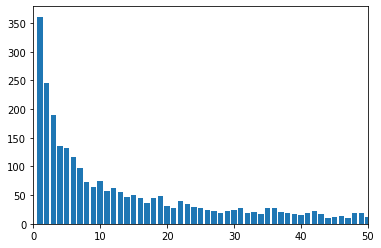

In [ ]:
plt.bar(dd.groupby('count').count().index.to_array(), dd.groupby('count').count().to_array())
plt.xlim(0,50)

We can observe, that the observation count for some categories are 1. This means, that we have only one data point to calculate the average and Target Encoding overfits to these values. Therefore, we need to adjust the calculation:

- if the number of observation is high, we want to use the mean of this category value
- if the number of observation is low, we want to use the global mean

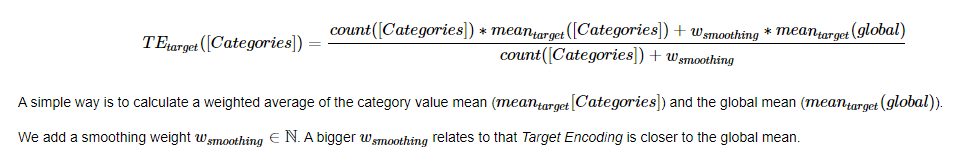

In [ ]:
feat = ['brand', 'cat_2']
w = 20

mean_global = df_train.target.mean()
te = df_train.groupby(feat)['target'].agg(['mean','count']).reset_index()
te['TE_brand_cat_2'] = ((te['mean']*te['count'])+(mean_global*w))/(te['count']+w)

df_train = df_train.sample(1e6, random_state=42).merge(te, on=feat, how='left')
df_valid = df_valid.merge( te, on=feat, how='left' )
df_test = df_test.merge( te, on=feat, how='left' )
df_valid['TE_brand_cat_2'] = df_valid['TE_brand_cat_2'].fillna(mean_global)
df_test['TE_brand_cat_2'] = df_test['TE_brand_cat_2'].fillna(mean_global)

In [ ]:
df_test.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,cat_0,cat_1,cat_2,cat_3,product_id_Categorify,brand_Categorify,mean,count,TE_brand_cat_2
0,2020-04-09 16:47:18 UTC,cart,1005100,samsung,144.89,604644674,16b2649b-56d9-47e8-afe9-c16d97af142b,0,2020-04-09 16:47:18,16,47,3,9,4,2020,construction,tools,light,NA,5,2,0.47816,1216099,0.478158
1,2020-04-09 16:47:18 UTC,cart,1005100,samsung,144.89,604644674,16b2649b-56d9-47e8-afe9-c16d97af142b,0,2020-04-09 16:47:18,16,47,3,9,4,2020,construction,tools,light,NA,5,2,0.47816,1216099,0.478158
2,2020-04-09 16:47:18 UTC,cart,1005100,samsung,144.89,604644674,16b2649b-56d9-47e8-afe9-c16d97af142b,0,2020-04-09 16:47:18,16,47,3,9,4,2020,construction,tools,light,NA,5,2,0.47816,1216099,0.478158
3,2020-04-09 16:47:18 UTC,cart,1005100,samsung,144.89,604644674,16b2649b-56d9-47e8-afe9-c16d97af142b,0,2020-04-09 16:47:18,16,47,3,9,4,2020,construction,tools,light,NA,5,2,0.47816,1216099,0.478158
4,2020-04-09 16:47:18 UTC,cart,1005100,samsung,144.89,604644674,16b2649b-56d9-47e8-afe9-c16d97af142b,0,2020-04-09 16:47:18,16,47,3,9,4,2020,construction,tools,light,NA,5,2,0.47816,1216099,0.478158


### Improve TargetEncoding with out-of-fold
We can still improve our Target Encoding function. We can even make it more generalizable, if we apply an out of fold calculation.

In our current definition, we use the full training dataset to Target Encode the training dataset and validation/test dataset. Therefore, we will likely overfit slightly on our training dataset, because we use the information from it to encode the categorical values. A better strategy is to use out of fold:

- use the full training dataset to encode the validation/test dataset
- split the training dataset in k-folds and encode the i-th fold by using all folds except of the i-th one


The following figure visualize the strategy for k=5:

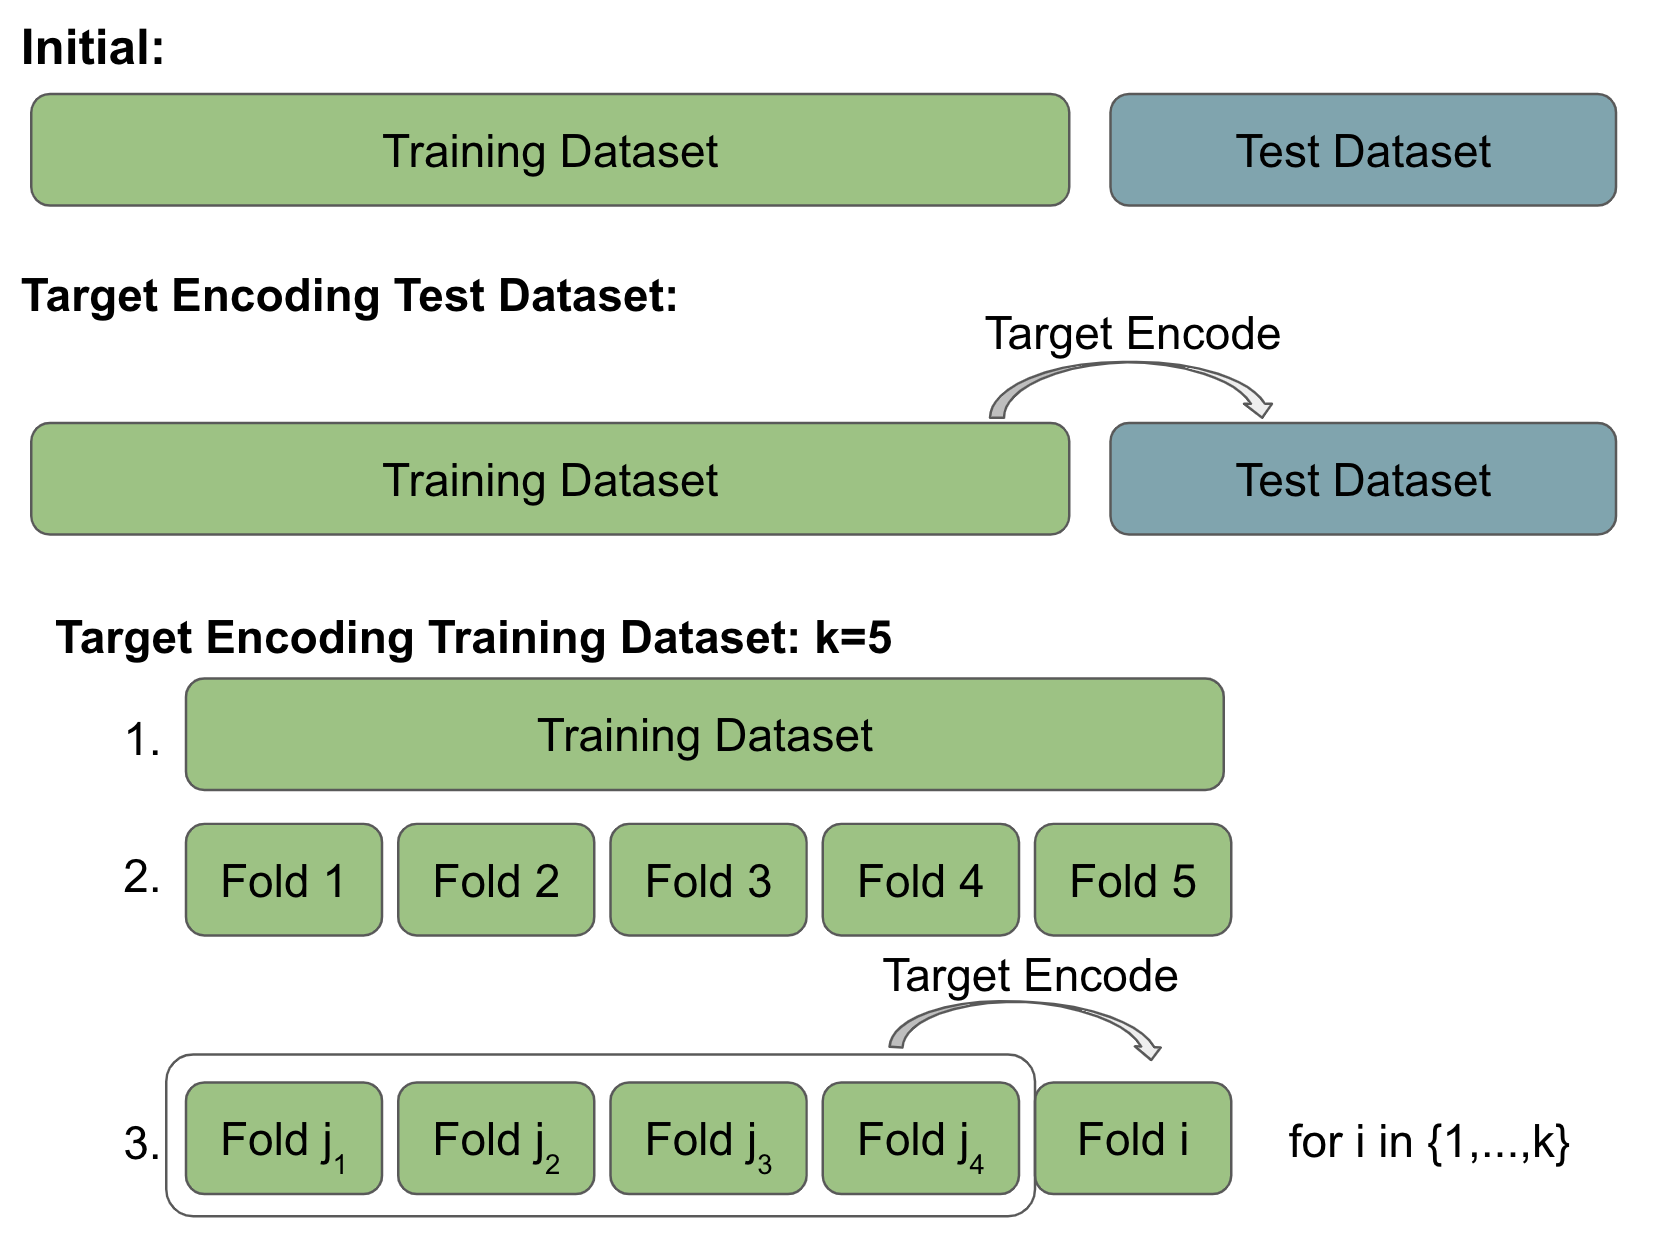

In [ ]:
def target_encode(train, valid, col, target, kfold=5, smooth=20):
    """
        train:  train dataset
        valid:  validation dataset
        col:   column which will be encoded (in the example RESOURCE)
        target: target column which will be used to calculate the statistic
    """
    
    # We assume that the train dataset is shuffled
    train['kfold'] = ((train.index) % kfold)
    # We keep the original order as cudf merge will not preserve the original order
    train['org_sorting'] = cupy.arange(len(train), dtype="int32")
    # We create the output column, we fill with 0
    col_name = '_'.join(col)
    train['TE_' + col_name] = 0.
    for i in range(kfold):
        ###################################
        # filter for out of fold
        # calculate the mean/counts per group category
        # calculate the global mean for the oof
        # calculate the smoothed TE
        # merge it to the original dataframe
        ###################################
        
        df_tmp = train[train['kfold']!=i]
        mn = df_tmp[target].mean()
        df_tmp = df_tmp[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
        df_tmp.columns = col + ['mean', 'count']
        df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', 'org_sorting', 'TE_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
        df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train['TE_' + col_name] = df_tmp_m['TE_' + col_name].fillna(mn).values

    
    ###################################
    # calculate the mean/counts per group for the full training dataset
    # calculate the global mean
    # calculate the smoothed TE
    # merge it to the original dataframe
    # drop all temp columns
    ###################################    
    
    df_tmp = train[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
    mn = train[target].mean()
    df_tmp.columns = col + ['mean', 'count']
    df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
    valid['org_sorting'] = cupy.arange(len(valid), dtype="int32")
    df_tmp_m = valid[col + ['org_sorting']].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    valid['TE_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    
    valid = valid.drop('org_sorting', axis=1)
    train = train.drop('kfold', axis=1)
    train = train.drop('org_sorting', axis=1)
    return(train, valid)

- Target Encoding calculates statistics of a target column given one or more categorical features
- Target Encoding smooths the statistics as a weighted average of the category value and the global statistic
- Target Encoding uses a out-of-fold strategy to prevent overfitting to the training dataset.

We can see the advantage of using Target Encoding as a feature engineering step. A tree-based model or a neural network learns the average probability for the category value. However, neither model is designed to prevent overfitting.

### Count encoding

*Count Encoding (CE)* calculates the frequency from one or more categorical features given the training dataset.

For example we can consider Count Encoding as the populiarity of an item or activity of an user.

Count Encoding creates a new feature, which can be used by the model for training. It groups categorical values based on the frequency together.

For example,

users, which have only 1 interaction in the datasets, are encoded with 1. Instead of having 1 datapoint per user, now, the model can learn a behavior pattern of these users at once.
products, which have many interactions in the datasets, are encoded with a high number. The model can learn to see them as top sellers and treat them, accordingly.

The advantage of Count Encoding is that the category values are grouped together based on behavior. Particularly in cases with only a few observation, a decision tree is not able to create a split and neural networks have only a few gradient descent updates for these values.

In [4]:
col = 'user_id'

df_train['org_sorting'] = cupy.arange(len(df_train), dtype="int32")
    
train_tmp = df_train[col].value_counts().reset_index()
train_tmp.columns = [col,  'CE_' + col]
df_tmp = df_train[[col, 'org_sorting']].merge(train_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
df_train['CE_' + col] = df_tmp['CE_' + col].fillna(0).values
df_train = df_train.drop('org_sorting', axis=1)
        
df_valid['org_sorting'] = cupy.arange(len(df_valid), dtype="int32")
df_tmp = df_valid[[col, 'org_sorting']].merge(train_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
df_valid['CE_' + col] = df_tmp['CE_' + col].fillna(0).values
df_valid = df_valid.drop('org_sorting', axis=1)

In [5]:
df_train.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,CE_user_id
0,2020-01-23 04:32:33 UTC,cart,100039953,appliances.personal.massager,kivi,267.44,512913139,9bebab16-bce8-43cd-ac97-f763ee4664dd,0,2020-01-23 04:32:33,4,32,3,23,1,2020,3
1,2020-01-23 04:32:36 UTC,cart,1004767,construction.tools.light,samsung,226.27,549154456,659387e4-032e-4e71-8b0b-3b90f0538f14,0,2020-01-23 04:32:36,4,32,3,23,1,2020,5
2,2020-01-23 04:32:38 UTC,cart,1003306,construction.tools.light,apple,614.79,585624798,41a24f4f-afb8-4342-ae6f-003aa968f82f,0,2020-01-23 04:32:38,4,32,3,23,1,2020,26
3,2020-01-23 04:32:38 UTC,cart,4804055,sport.bicycle,apple,192.07,525860806,70b5ed9a-4395-481e-9f91-d811ced8a4c3,0,2020-01-23 04:32:38,4,32,3,23,1,2020,21
4,2020-01-23 04:32:43 UTC,cart,1005100,construction.tools.light,samsung,141.06,599724791,bc35693d-9c73-457f-a7ef-8ced2f0bb729,0,2020-01-23 04:32:43,4,32,3,23,1,2020,23


### Binning

*Binning* maps multiple ordinal categorical or numerical features into groups. It is mainly applied to numerical features:

- prevent overfitting by grouping values together
- enables us to add some expert knowledge into the model
- most simple case: binary flags, e.g. features is greater than 0

Examples:
- binning weekdays into weekday and weekend
- binning hours into morning, early afternoon, late afternoon, evening and night
- binning age into child, adlult and retired

We can take a look on the hour of the day. We can see multiple patterns:
- 0-3 Night: Low purchase probability
- 4-7 Early morning: Mid purchase probability
- 8-14 Morning/Lunch: Higher purchase probability
- 15-20 Afternoon: Low purchase probability
- 21-23: Evening: High purchase probability

In [4]:
df_train[['ts_hour', 'target']].groupby('ts_hour').agg(['count', 'mean']).head(10)

target          
          count      mean
ts_hour                  
21       117724  0.363027
1         99235  0.251756
20       197950  0.348790
14       646275  0.358253
22        73302  0.377643
2        207125  0.281960
0         58535  0.304860
19       321995  0.341636
23        50577  0.379461
17       548159  0.338296

In [5]:
hour = list(range(0,24))
hour_bin = [0]*4 + [1]*4 + [2]*7 + [3]*6 + [4]*3

data = cudf.DataFrame({
    'hour': hour,
    'hour_bin': hour_bin,
})

In [6]:
data.head(10)

,hour,hour_bin
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
5,5,1
6,6,1
7,7,1
8,8,2
9,9,2


In [7]:
df_train = df_train.merge(data, how='left', right_on='hour', left_on='ts_hour')

In [8]:
df_train[['hour_bin', 'target']].groupby('hour_bin').agg(['count', 'mean'])

target          
            count      mean
hour_bin                   
1         2714395  0.375762
2         4996207  0.383043
0          752027  0.308982
4          241603  0.370902
3         2791013  0.334824

Binning the numerical features reduces the cardinality (# of unique values). Therefore, a model can easier learn the relationship to the target variables, as there are more observation per category. In addition, binning prevents overfitting.

Another reason to apply binning is to standardize numeric variables per category group. The datasets provides information about the product category (cat_1) and price information.

For example, the headphones and smartphones have a different price distribution.

- We can probably buy good headphones between 100−200
- For a good smartphone, prices are probably in the range of 400−1200

Therefore, the buying behavior should be different depending on the price per category (what is a good deal).

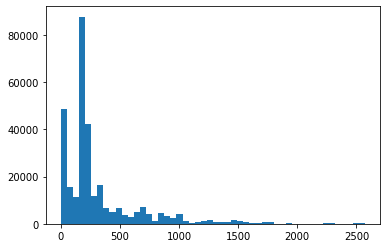

In [9]:
plt.hist(df_train[df_train['cat_2']=='headphone'].price.to_pandas(), bins=50)
plt.show()

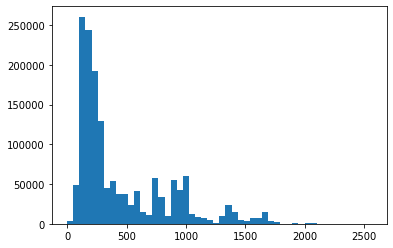

In [10]:
plt.hist(df_train[df_train['cat_1']=='smartphone'].price.to_pandas(), bins=50)
plt.show()

In [11]:
print('Headphones mean price: ' + str(df_train[df_train['cat_2']=='headphone'].price.mean()) + ' median price: ' + str(df_train[df_train['cat_2']=='headphone'].price.median()))
print('Smartphones mean price: ' + str(df_train[df_train['cat_1']=='smartphone'].price.mean()) + ' median price: ' + str(df_train[df_train['cat_1']=='smartphone'].price.median()))

Headphones mean price: 317.2112100416274 median price: 189.84
Smartphones mean price: 456.26767214233337 median price: 263.84


Based on the category tree, we want to bin the prices as a combination of cat_0, cat_1 and cat_2.

In [12]:
df_train['cat_012'] = df_train['cat_0'].astype(str) + '_' + df_train['cat_1'].astype(str) + '_' + df_train['cat_2'].astype(str)
q_list = [0.1, 0.25, 0.5, 0.75, 0.9]

We calculate the quantiles per category group and then merge the quantile to the original dataframe.

In [13]:
for q_value in q_list:
    q = df_train[['cat_012', 'price']].groupby(['cat_012']).quantile(q_value)
    q = q.reset_index()
    q.columns = ['cat_012', 'price' + str(q_value)]
    df_train = df_train.merge(q, how='left', on='cat_012')

Afterwards, we loop through the columns and update the price_bin depending, if the price is between quantiles.

In [14]:
df_train['price_bin'] = -1

for i, q_value in enumerate(q_list):
    if i == 0:
        df_train.loc[df_train['price']<=df_train['price' + str(q_value)], 'price_bin'] = i
    else:
        df_train.loc[(df_train['price']>df_train['price' + str(q_list[i-1])]) & (df_train['price']<=df_train['price' + str(q_value)]), 'price_bin'] = i
        
df_train.loc[df_train['price']>df_train['price' + str(q_value)], 'price_bin'] = i+1

In [15]:
df_train[df_train['price_bin']==3][['price', 'price0.1', 'price0.25', 'price0.5', 'price0.75', 'price0.9', 'price_bin']].drop_duplicates()

,price,price0.1,price0.25,price0.5,price0.75,price0.9,price_bin
309305,7.70,4.12,5.56,7.68,11.58,16.99,3
1105820,7.72,3.06,6.15,7.70,12.87,25.71,3
143278,7.72,3.73,4.63,7.71,15.37,24.66,3
29097,7.72,4.12,5.56,7.68,11.58,16.99,3
9451362,7.74,3.73,4.63,7.71,15.37,24.66,3
...,...,...,...,...,...,...,...
107240,766.73,254.81,308.63,514.56,767.81,1283.73,3
775100,766.82,254.81,308.63,514.56,767.81,1283.73,3
1729643,767.05,254.81,308.63,514.56,767.81,1283.73,3
716072,767.79,254.81,308.63,514.56,767.81,1283.73,3


In [16]:
df_train = df_train.drop(['price' + str(x) for x in q_list], axis=1)

We can see the pattern, that products in a lower quantile 0-10% and 10-25% have lower purchase probabilities.

In [17]:
df_train[['price_bin', 'target']].groupby('price_bin').agg(['count', 'mean'])

target          
             count      mean
price_bin                   
1          1729591  0.357154
2          2849441  0.366890
0          1193665  0.335035
5          1139560  0.365359
4          1696056  0.373025
3          2886932  0.373441

Now, let's take a look on ts_weekday.

In [18]:
df_train[['ts_weekday', 'target']].groupby('ts_weekday').agg(['count', 'mean'])

target          
              count      mean
ts_weekday                   
1           1428105  0.401288
2           1419514  0.404012
0           1509801  0.411447
5           1839756  0.329605
4           2015682  0.280888
6           1788988  0.406825
3           1493399  0.349564

In [19]:
weekday = list(range(0,7))
weekday_bin = [0, 1, 1, 2, 2, 2, 0]

data = cudf.DataFrame({
    'weekday': weekday,
    'weekday_bin': weekday_bin,
})

In [20]:
df_train = df_train.merge(data, how='left', right_on='weekday', left_on='ts_weekday')

In [21]:
df_train[['weekday_bin', 'target']].groupby('weekday_bin').agg(['count', 'mean'])

target          
               count      mean
weekday_bin                   
1            2847619  0.402646
2            5348837  0.316819
0            3298789  0.408940

It is maybe counterintuitive:
* the highest days are Sunday and Monday - a hypothesis could be that people shop on Sunday evening and the first day of the week
* the lowest days are Thur-Sat - a hypothesis could be that Thu/Fri is end of 
 week and people are finishing up their work and have no time to do online shopping
* Saturday is maybe a day go outside

### Normalization

*Normalization* is required to enable neural networks to leverage numerical features. Tree-based models do not require normalization as they define the split independent of the scale of a feature. Without normalization, neural networks are difficult to train. The image visualizes the loss surface and the gradient updates for non-normalized input (left) and normalized input (right).

We will first generate some numerical features with the feature engineering that we also covered in previous steps.

The reason is that different numerical features have different scales. When we combine the features in a hidden layer, the different scales make it more difficult to extract patterns from it.

Normalization Techniques
After we outline the importance for normalizing the numerical input feature, we will discuss different strategy to achieve a normal distributed input feature:
- Normalization with mean/std
- Log-based normalization
- Scale to 0-1
- Gauss Rank (separate notebook)
- Power transfomer

In [22]:
def target_encode(train, valid, col, target, kfold=5, smooth=20, gpu=True):
    """
        train:  train dataset
        valid:  validation dataset
        col:   column which will be encoded (in the example RESOURCE)
        target: target column which will be used to calculate the statistic
    """
    
    # We assume that the train dataset is shuffled
    train['kfold'] = ((train.index) % kfold)
    # We keep the original order as cudf merge will not preserve the original order
    if gpu:
        train['org_sorting'] = cupy.arange(len(train), dtype="int32")
    else:
        train['org_sorting'] = np.arange(len(train), dtype="int32")
    # We create the output column, we fill with 0
    col_name = '_'.join(col)
    train['TE_' + col_name] = 0.
    for i in range(kfold):
        ###################################
        # filter for out of fold
        # calculate the mean/counts per group category
        # calculate the global mean for the oof
        # calculate the smoothed TE
        # merge it to the original dataframe
        ###################################
        
        df_tmp = train[train['kfold']!=i]
        mn = df_tmp[target].mean()
        df_tmp = df_tmp[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
        df_tmp.columns = col + ['mean', 'count']
        df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', 'org_sorting', 'TE_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
        df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train['TE_' + col_name] = df_tmp_m['TE_' + col_name].fillna(mn).values

    
    ###################################
    # calculate the mean/counts per group for the full training dataset
    # calculate the global mean
    # calculate the smoothed TE
    # merge it to the original dataframe
    # drop all temp columns
    ###################################    
    
    df_tmp = train[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
    mn = train[target].mean()
    df_tmp.columns = col + ['mean', 'count']
    df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
    if gpu:
        valid['org_sorting'] = cupy.arange(len(valid), dtype="int32")
    else:
        valid['org_sorting'] = np.arange(len(valid), dtype="int32")
    df_tmp_m = valid[col + ['org_sorting']].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    valid['TE_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    
    valid = valid.drop('org_sorting', axis=1)
    train = train.drop('kfold', axis=1)
    train = train.drop('org_sorting', axis=1)
    return(train, valid)

In [23]:
cats = [['cat_0'], ['cat_1'], ['cat_2'], ['cat_0', 'cat_1', 'cat_2'], ['ts_hour'], ['ts_weekday'], ['ts_weekday', 'ts_hour', 'cat_2', 'brand']]

for cat in cats:
    df_train, df_valid = target_encode(df_train, df_valid, cat, 'target')

In [25]:
def count_encode(train, valid, col, gpu=True):
    """
        train:  train dataset
        valid:  validation dataset
        col:    column which will be count encoded (in the example RESOURCE)
    """
    # We keep the original order as cudf merge will not preserve the original order
    if gpu:
        train['org_sorting'] = cupy.arange(len(train), dtype="int32")
    else:
        train['org_sorting'] = np.arange(len(train), dtype="int32")
    
    train_tmp = train[col].value_counts().reset_index()
    train_tmp.columns = [col,  'CE_' + col]
    df_tmp = train[[col, 'org_sorting']].merge(train_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    train['CE_' + col] = df_tmp['CE_' + col].fillna(0).values
        
    if gpu:
        valid['org_sorting'] = cupy.arange(len(valid), dtype="int32")
    else:
        valid['org_sorting'] = np.arange(len(valid), dtype="int32")
    df_tmp = valid[[col, 'org_sorting']].merge(train_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    valid['CE_' + col] = df_tmp['CE_' + col].fillna(0).values
    
    valid = valid.drop('org_sorting', axis=1)
    train = train.drop('org_sorting', axis=1)
    return(train, valid)

In [26]:
cats = ['brand', 'user_id', 'product_id', 'cat_0', 'cat_1', 'cat_2']

for cat in cats:
    df_train, df_valid = count_encode(df_train, df_valid, cat, gpu=True)

In [27]:
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,cat_0,cat_1,cat_2,cat_3,hour,hour_bin,cat_012,price_bin,weekday,weekday_bin,TE_cat_0,TE_cat_1,TE_cat_2,TE_cat_0_cat_1_cat_2,TE_ts_hour,TE_ts_weekday,TE_ts_weekday_ts_hour_cat_2_brand,CE_brand,CE_user_id,CE_product_id,CE_cat_0,CE_cat_1,CE_cat_2
0,2020-01-23 08:22:39 UTC,cart,13201032,brw,207.47,513115689,520e7567-c1f3-4322-993e-aa4df1ff42ac,0,2020-01-23 08:22:39,8,22,3,23,1,2020,furniture,bedroom,bed,NA,8,2,furniture_bedroom_bed,4,3,2,0.312571,0.359570,0.324688,0.324688,0.390130,0.349599,0.273233,11364,7,50,336494,125236,50304
1,2020-01-23 08:22:41 UTC,cart,1307058,apple,1281.89,573953156,11b2fb95-fcaa-41c2-904c-7c456cc9e9f3,0,2020-01-23 08:22:41,8,22,3,23,1,2020,electronics,audio,headphone,NA,8,2,electronics_audio_headphone,5,3,2,0.360921,0.361619,0.365271,0.365271,0.390216,0.349541,0.421725,2040287,8,969,2577712,387516,305568
2,2020-01-23 08:22:42 UTC,cart,1005177,samsung,849.16,515852078,05622990-d291-4ce3-8e2f-4be65c96707e,0,2020-01-23 08:22:42,8,22,3,23,1,2020,construction,tools,light,NA,8,2,construction_tools_light,4,3,2,0.450553,0.450018,0.456834,0.457670,0.390174,0.349531,0.490076,2329847,48,18073,3375478,3319883,3184510
3,2020-01-23 08:22:43 UTC,cart,5701000,pioneer,61.78,545280126,1f03212a-2582-4d59-844e-05b27e82f54b,0,2020-01-23 08:22:43,8,22,3,23,1,2020,electronics,video,tv,NA,8,2,electronics_video_tv,0,3,2,0.361095,0.315736,0.313373,0.313373,0.390190,0.349571,0.409333,19737,8,152,2577712,176316,164102
4,2020-01-23 08:22:44 UTC,cart,1005023,xiaomi,322.95,581301439,94ead800-d5dc-43fc-b690-508afd45936f,0,2020-01-23 08:22:44,8,22,3,23,1,2020,construction,tools,light,NA,8,2,construction_tools_light,3,3,2,0.450266,0.449712,0.456533,0.457381,0.390178,0.349578,0.369724,1085216,6,2688,3375478,3319883,3184510


In [28]:
df_train.columns

Index(['event_time', 'event_type', 'product_id', 'brand', 'price', 'user_id',
       'user_session', 'target', 'timestamp', 'ts_hour', 'ts_minute',
       'ts_weekday', 'ts_day', 'ts_month', 'ts_year', 'cat_0', 'cat_1',
       'cat_2', 'cat_3', 'hour', 'hour_bin', 'cat_012', 'price_bin', 'weekday',
       'weekday_bin', 'TE_cat_0', 'TE_cat_1', 'TE_cat_2',
       'TE_cat_0_cat_1_cat_2', 'TE_ts_hour', 'TE_ts_weekday',
       'TE_ts_weekday_ts_hour_cat_2_brand', 'CE_brand', 'CE_user_id',
       'CE_product_id', 'CE_cat_0', 'CE_cat_1', 'CE_cat_2'],
      dtype='object')

Let's normalize the features: price, TE_ts_weekday_ts_hour_cat_2_brand, CE_cat_2

Text(0.5, 1.0, 'Histogram minmax')

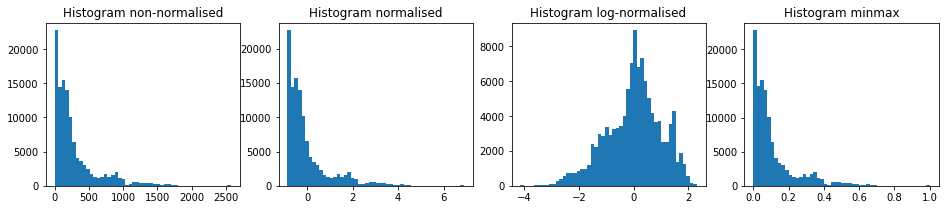

In [29]:
cat = 'price'

X = df_train[cat]
X_norm = (X-X.mean())/X.std()

X_log = np.log(X.to_pandas()+1)
X_log_norm = (X_log-X_log.mean())/X_log.std()

X_minmax = ((X-X.min())/(X.max()-X.min()))

fig, axs = plt.subplots(1, 4, figsize=(16,3))
axs[0].hist(X.sample(frac=0.01).to_pandas(), bins=50)
axs[0].set_title('Histogram non-normalised')
axs[1].hist(X_norm.sample(frac=0.01).to_pandas(), bins=50)
axs[1].set_title('Histogram normalised')
axs[2].hist(X_log_norm.sample(frac=0.01), bins=50)
axs[2].set_title('Histogram log-normalised')
axs[3].hist(X_minmax.sample(frac=0.01).to_pandas(), bins=50)
axs[3].set_title('Histogram minmax')

Text(0.5, 1.0, 'Histogram minmax')

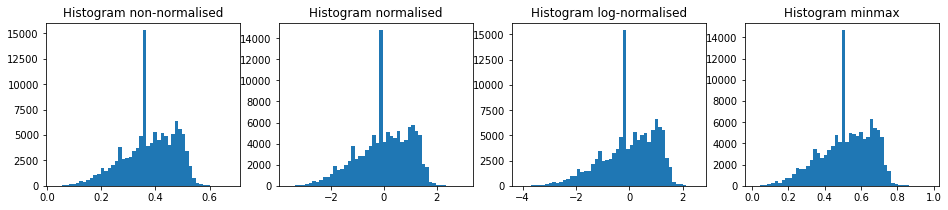

In [30]:
cat = 'TE_ts_weekday_ts_hour_cat_2_brand'

X = df_train[cat]
X_norm = (X-X.mean())/X.std()

X_log = np.log(X.to_pandas()+1)
X_log_norm = (X_log-X_log.mean())/X_log.std()

X_minmax = ((X-X.min())/(X.max()-X.min()))

fig, axs = plt.subplots(1, 4, figsize=(16,3))
axs[0].hist(X.sample(frac=0.01).to_pandas(), bins=50)
axs[0].set_title('Histogram non-normalised')
axs[1].hist(X_norm.sample(frac=0.01).to_pandas(), bins=50)
axs[1].set_title('Histogram normalised')
axs[2].hist(X_log_norm.sample(frac=0.01), bins=50)
axs[2].set_title('Histogram log-normalised')
axs[3].hist(X_minmax.sample(frac=0.01).to_pandas(), bins=50)
axs[3].set_title('Histogram minmax')

Text(0.5, 1.0, 'Histogram minmax')

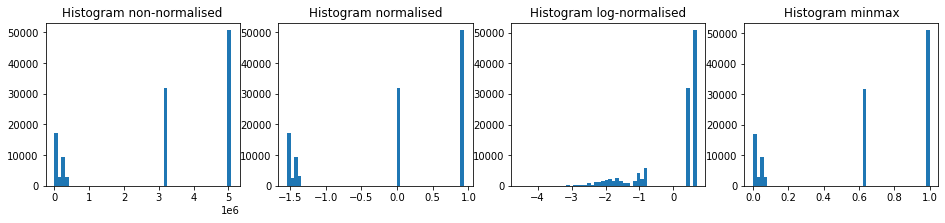

In [31]:
cat = 'CE_cat_2'

X = df_train[cat]
X_norm = (X-X.mean())/X.std()

X_log = np.log(X.to_pandas()+1)
X_log_norm = (X_log-X_log.mean())/X_log.std()

X_minmax = ((X-X.min())/(X.max()-X.min()))

fig, axs = plt.subplots(1, 4, figsize=(16,3))
axs[0].hist(X.sample(frac=0.01).to_pandas(), bins=50)
axs[0].set_title('Histogram non-normalised')
axs[1].hist(X_norm.sample(frac=0.01).to_pandas(), bins=50)
axs[1].set_title('Histogram normalised')
axs[2].hist(X_log_norm.sample(frac=0.01), bins=50)
axs[2].set_title('Histogram log-normalised')
axs[3].hist(X_minmax.sample(frac=0.01).to_pandas(), bins=50)
axs[3].set_title('Histogram minmax')

### Gauss rank

Gauss Rank* transforms any arbitrary distribution to a Gaussian normal distribution by

1. Compute the rank (or sort the values ascending)
2. Scale the values linearly from -1 to +1
3. Apply the erfinv function

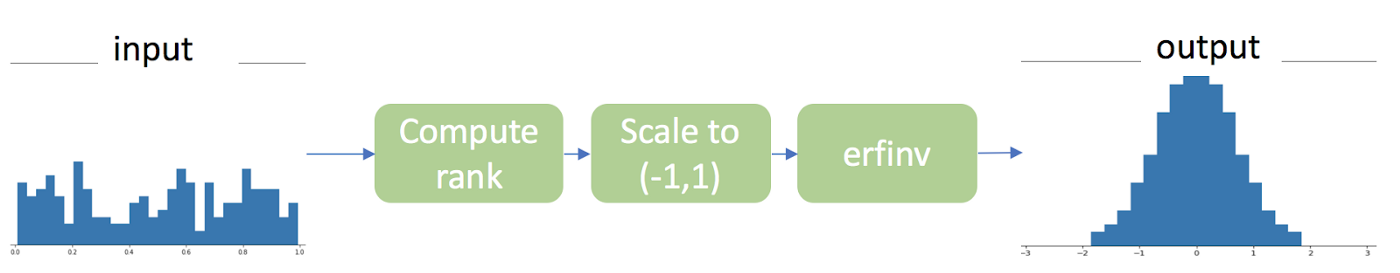

In [32]:
import cupy as cp
from cupyx.scipy.special import erfinv
import cudf as gd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import erfinv as sp_erfinv

In [33]:
def gaussrank_cpu(data, epsilon = 1e-6):
    r_cpu = data.argsort().argsort()
    r_cpu = (r_cpu/r_cpu.max()-0.5)*2 # scale to (-1,1)
    r_cpu = np.clip(r_cpu,-1+epsilon,1-epsilon)
    r_cpu = sp_erfinv(r_cpu)
    return(r_cpu)

def gaussrank_gpu(data, epsilon = 1e-6):
    r_gpu = data.argsort().argsort()
    r_gpu = (r_gpu/r_gpu.max()-0.5)*2 # scale to (-1,1)
    r_gpu = cp.clip(r_gpu,-1+epsilon,1-epsilon)
    r_gpu = erfinv(r_gpu)
    return(r_gpu)

Text(0.5, 1.0, 'Histogram Gauss Rank')

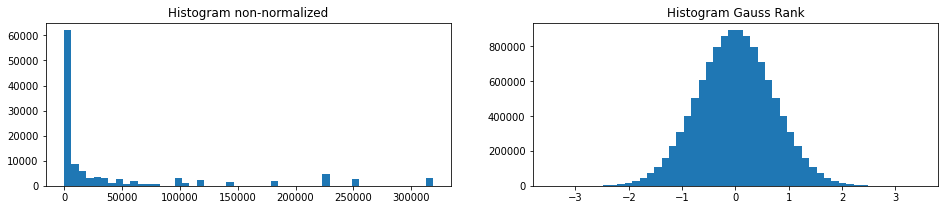

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(16,3))
col = 'CE_product_id'
data_sample = df_train[col].sample(frac=0.01)
axs[0].hist(data_sample.to_pandas().values, bins=50)
axs[1].hist(cp.asnumpy(gaussrank_gpu(df_train[col].values)), bins=50)
axs[0].set_title('Histogram non-normalized')
axs[1].set_title('Histogram Gauss Rank')

Let's normalize the features price, TE_ts_weekday_ts_hour_cat_2_brand and CE_cat_2 with GaussRank, and plot the non-normalized and normalized values

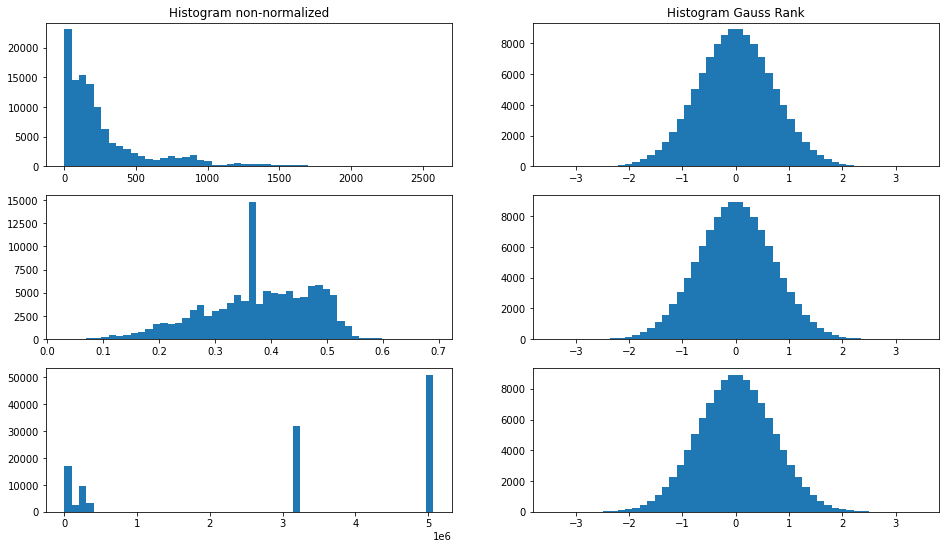

In [35]:
fig, axs = plt.subplots(3, 2, figsize=(16,9))
for i, col in enumerate(['price', 'TE_ts_weekday_ts_hour_cat_2_brand', 'CE_cat_2']):
    data_sample = df_train[col].sample(frac=0.01)
    axs[i, 0].hist(data_sample.to_pandas(), bins=50)
    axs[i, 1].hist(cp.asnumpy(gaussrank_gpu(data_sample.values)), bins=50)
    if i==0:
        axs[i, 0].set_title('Histogram non-normalized')
        axs[i, 1].set_title('Histogram Gauss Rank')

### Timeseries historical events

Many real-world recommendation systems contain time information. The system normally logs events with a timestamp. Tree-based or deep learning based models usually only uses the information from the datapoint itself for the prediction and they have difficulties to capture relationships over multiple datapoints.

Let's take a look at a simple example. Let's assume we have the interaction events of an itemid, userid and action with the timestamp.

In [36]:
itemid = [1000001]*10 + [1000002]*5 + [1000001]*5 + [1000002]*5 + [1000001]*1 + [1000002]*1 + [1000001]*2 + [1000002]*2
itemid += [1000001]*3 + [1000002]*2 + [1000001]*1 + [1000002]*1 + [1000001]*6 + [1000002]*3 + [1000001]*2 + [1000002]*2
userid = np.random.choice(list(range(10000)), len(itemid))
action = np.random.choice(list(range(2)), len(itemid), p=[0.2, 0.8])
timestamp = [pd.to_datetime('2020-01-01')]*15
timestamp += [pd.to_datetime('2020-01-02')]*10
timestamp += [pd.to_datetime('2020-01-03')]*2
timestamp += [pd.to_datetime('2020-01-04')]*4
timestamp += [pd.to_datetime('2020-01-05')]*5
timestamp += [pd.to_datetime('2020-01-07')]*2
timestamp += [pd.to_datetime('2020-01-08')]*9
timestamp += [pd.to_datetime('2020-01-09')]*4

data = pd.DataFrame({
    'itemid': itemid,
    'userid': userid,
    'action': action,
    'timestamp': timestamp
})

data = cudf.from_pandas(data)

data[data['itemid']==1000001]

,itemid,userid,action,timestamp
0,1000001,6491,1,2020-01-01
1,1000001,5429,0,2020-01-01
2,1000001,7591,1,2020-01-01
3,1000001,9085,1,2020-01-01
4,1000001,8408,0,2020-01-01
5,1000001,1771,1,2020-01-01
6,1000001,2784,1,2020-01-01
7,1000001,3083,0,2020-01-01
8,1000001,3395,1,2020-01-01
9,1000001,6500,1,2020-01-01


We can extract many interesting features based on the history, such as

- the sum number of actions of the last day, last 3 days or last 7 days
- the average number of actions of the last day, last 3 days or last 7 days
- the average probability of the last day, last 3 days or last 7 days
etc.

In general, these operations are called window function and uses .rolling() function. For each row, the function looks at a window (# of rows around it) and apply a certain function to it.

Current, our data is on a userid and itemid level. First, we need to aggregate it on the level, we want to apply the window function.

In [37]:
data_window = data[['itemid', 'timestamp', 'action']].groupby(['itemid', 'timestamp']).agg(['count', 'sum']).reset_index()
data_window.columns = ['itemid', 'timestamp', 'count', 'sum']
data_window.index = data_window['timestamp']

data_window

,itemid,timestamp,count,sum
timestamp,,,,
2020-01-01,1000002,2020-01-01,5,4
2020-01-08,1000001,2020-01-08,6,5
2020-01-02,1000001,2020-01-02,5,4
2020-01-07,1000001,2020-01-07,1,1
2020-01-03,1000001,2020-01-03,1,1
2020-01-09,1000001,2020-01-09,2,2
2020-01-04,1000001,2020-01-04,2,2
2020-01-05,1000001,2020-01-05,3,3
2020-01-08,1000002,2020-01-08,3,2


We are interested how many positive interaction an item had on the previous day. Next, we want to groupby our dataframe by itemid. Then we apply the rolling function for two days (2D).

Note: To use the rolling function with days, the dataframe index has to by a timestamp.

We can see that every row contains the sum of the row value + the previous row value. For example, itemid=1000001 for data 2020-01-02 counts 15 observations and sums 12 positive interactions.

In [38]:
offset = '3D'

data_window_roll = data_window[['itemid', 'count', 'sum']].groupby(['itemid']).rolling(offset).sum().drop('itemid', axis=1)
data_window_roll

count  sum
itemid  timestamp             
1000001 2020-01-08      6    5
        2020-01-02     11    9
        2020-01-07      1    1
        2020-01-03     13   11
        2020-01-09      2    2
        2020-01-04     17   15
        2020-01-05      9    9
        2020-01-01     30   25
1000002 2020-01-01      5    4
        2020-01-08      3    2
        2020-01-07      4    3
        2020-01-09      6    5
        2020-01-03     12   10
        2020-01-05      9    8
        2020-01-04     11   10
        2020-01-02     21   18

If we take a look on the calculations, we see that the .rolling() inclues the value from the current row, as well. This could be a kind of data leakage. Therefore, we shift the values by one row.

In [39]:
data_window_roll = data_window_roll.reset_index()
data_window_roll.columns = ['itemid', 'timestamp', 'count_' + offset, 'sum_' + offset]
data_window_roll[['count_' + offset, 'sum_' + offset]] = data_window_roll[['count_' + offset, 'sum_' + offset]].shift(1)
data_window_roll.loc[data_window_roll['itemid']!=data_window_roll['itemid'].shift(1), ['count_' + offset, 'sum_' + offset]] = 0
data_window_roll['avg_' + offset] = data_window_roll['sum_' + offset]/data_window_roll['count_' + offset]
data_window_roll

,itemid,timestamp,count_3D,sum_3D,avg_3D
0,1000001,2020-01-08,<NA>,<NA>,<NA>
1,1000001,2020-01-02,6,5,0.833333333
2,1000001,2020-01-07,11,9,0.818181818
3,1000001,2020-01-03,1,1,1.0
4,1000001,2020-01-09,13,11,0.846153846
5,1000001,2020-01-04,2,2,1.0
6,1000001,2020-01-05,17,15,0.882352941
7,1000001,2020-01-01,9,9,1.0
8,1000002,2020-01-01,0,0,NaN
9,1000002,2020-01-08,5,4,0.8


After we calculated the aggregated values and applied the window function, we want to merge it to our original dataframe.

In [40]:
data = data.merge(data_window_roll, how='left', on=['itemid', 'timestamp'])
data

,itemid,userid,action,timestamp,count_3D,sum_3D,avg_3D
0,1000001,6491,1,2020-01-01,9,9,1.0
1,1000001,5429,0,2020-01-01,9,9,1.0
2,1000001,7591,1,2020-01-01,9,9,1.0
3,1000001,9085,1,2020-01-01,9,9,1.0
4,1000001,8408,0,2020-01-01,9,9,1.0
5,1000001,1771,1,2020-01-01,9,9,1.0
6,1000001,2784,1,2020-01-01,9,9,1.0
7,1000001,3083,0,2020-01-01,9,9,1.0
8,1000001,3395,1,2020-01-01,9,9,1.0
9,1000001,6500,1,2020-01-01,9,9,1.0


In [41]:
offset = '7D'

data_window_roll = data_window[['itemid', 'count', 'sum']].groupby(['itemid']).rolling(offset).sum().drop('itemid', axis=1)
data_window_roll = data_window_roll.reset_index()
data_window_roll.columns = ['itemid', 'timestamp', 'count_' + offset, 'sum_' + offset]
data_window_roll[['count_' + offset, 'sum_' + offset]] = data_window_roll[['count_' + offset, 'sum_' + offset]].shift(1)
data_window_roll.loc[data_window_roll['itemid']!=data_window_roll['itemid'].shift(1), ['count_' + offset, 'sum_' + offset]] = 0
data_window_roll['avg_' + offset] = data_window_roll['sum_' + offset]/data_window_roll['count_' + offset]
data = data.merge(data_window_roll, how='left', on=['itemid', 'timestamp'])
data

,itemid,userid,action,timestamp,count_3D,sum_3D,avg_3D,count_7D,sum_7D,avg_7D
0,1000001,6491,1,2020-01-01,9,9,1.0,20,18,0.9
1,1000001,5429,0,2020-01-01,9,9,1.0,20,18,0.9
2,1000001,7591,1,2020-01-01,9,9,1.0,20,18,0.9
3,1000001,9085,1,2020-01-01,9,9,1.0,20,18,0.9
4,1000001,8408,0,2020-01-01,9,9,1.0,20,18,0.9
5,1000001,1771,1,2020-01-01,9,9,1.0,20,18,0.9
6,1000001,2784,1,2020-01-01,9,9,1.0,20,18,0.9
7,1000001,3083,0,2020-01-01,9,9,1.0,20,18,0.9
8,1000001,3395,1,2020-01-01,9,9,1.0,20,18,0.9
9,1000001,6500,1,2020-01-01,9,9,1.0,20,18,0.9


Let's get the # of purchases per product in the 7 days before.

In [43]:
# cuDF does not support date32, right now. We use pandas to transform the timestamp in only date values.
df_train['date'] = cudf.from_pandas(pd.to_datetime(df_train['timestamp'].to_pandas()).dt.date)

In [44]:
offset = '7D'

data_window = df_train[['product_id', 'date', 'target']].groupby(['product_id', 'date']).agg(['count', 'sum']).reset_index()
data_window.columns = ['product_id', 'date', 'count', 'sum']
data_window.index = data_window['date']

data_window_roll = data_window[['product_id', 'count', 'sum']].groupby(['product_id']).rolling(offset).sum().drop('product_id', axis=1)
data_window_roll = data_window_roll.reset_index()
data_window_roll.columns = ['product_id', 'date', 'count_' + offset, 'sum_' + offset]
data_window_roll[['count_' + offset, 'sum_' + offset]] = data_window_roll[['count_' + offset, 'sum_' + offset]].shift(1)
data_window_roll.loc[data_window_roll['product_id']!=data_window_roll['product_id'].shift(1), ['count_' + offset, 'sum_' + offset]] = 0
data_window_roll['avg_' + offset] = data_window_roll['sum_' + offset]/data_window_roll['count_' + offset]
data = df_train.merge(data_window_roll, how='left', on=['product_id', 'date'])
data.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,cat_0,cat_1,cat_2,cat_3,hour,hour_bin,price_bin,weekday,weekday_bin,TE_cat_0,TE_cat_1,TE_cat_2,TE_cat_0_cat_1_cat_2,TE_ts_hour,TE_ts_weekday,TE_ts_weekday_ts_hour_cat_2_brand,CE_brand,CE_user_id,CE_product_id,CE_cat_0,CE_cat_1,CE_cat_2,date,count_7D,sum_7D,avg_7D
0,2020-01-23 05:51:54 UTC,cart,1004767,samsung,226.27,604877512,d8340c6c-ea06-4e9d-8c35-91a794ec4fe1,0,2020-01-23 05:51:54,5,51,3,23,1,2020,construction,tools,light,NA,5,1,2,3,2,0.450266,0.449712,0.456533,0.457381,0.373932,0.349578,0.484851,2329847,2,318753,3375478,3319883,3184510,2020-01-23,4584,2499,0.545157
1,2020-01-23 05:51:57 UTC,cart,100043749,defacto,7.70,584393413,e6825e0a-2882-46c4-a181-66b4d3f51d77,0,2020-01-23 05:51:57,5,51,3,23,1,2020,appliances,personal,massager,NA,5,1,0,3,2,0.343637,0.386527,0.393561,0.393561,0.373823,0.349599,0.345413,19306,18,42,1531852,306000,277531,2020-01-23,8,2,0.250000
2,2020-01-23 05:51:58 UTC,cart,1005160,xiaomi,167.57,593241453,8768b7f8-67aa-437d-9750-27008f77354a,0,2020-01-23 05:51:58,5,51,3,23,1,2020,construction,tools,light,NA,5,1,2,3,2,0.450141,0.449635,0.456450,0.457303,0.373849,0.349541,0.368587,1085216,5,120163,3375478,3319883,3184510,2020-01-23,1547,467,0.301875
3,2020-01-23 05:52:00 UTC,cart,1005160,xiaomi,167.57,593241453,8768b7f8-67aa-437d-9750-27008f77354a,0,2020-01-23 05:52:00,5,52,3,23,1,2020,construction,tools,light,NA,5,1,2,3,2,0.450553,0.450018,0.456834,0.457670,0.374013,0.349531,0.374806,1085216,5,120163,3375478,3319883,3184510,2020-01-23,1547,467,0.301875
4,2020-01-23 05:52:01 UTC,cart,100009497,arcodoro,21.36,516498608,543260b0-6e6f-492d-b4e3-4380f4bb7329,0,2020-01-23 05:52:01,5,52,3,23,1,2020,medicine,tools,tonometer,NA,5,1,2,3,2,0.303333,0.449727,0.303333,0.303333,0.374066,0.349571,0.418171,714,9,129,5011,3319883,5011,2020-01-23,5,2,0.400000


### Differences

Another category of powerful features is to calculate the differences to previous datapoints based on a timestamp. For example, we can calculate if the price changed of a product and how much the price change was.

In [4]:
itemid = [1000001]*10 + [1000002]*5 + [1000001]*5 + [1000002]*5 + [1000001]*1 + [1000002]*1 + [1000001]*2 + [1000002]*2
itemid += [1000001]*3 + [1000002]*2 + [1000001]*1 + [1000002]*1 + [1000001]*6 + [1000002]*3 + [1000001]*2 + [1000002]*2
userid = np.random.choice(list(range(10000)), len(itemid))
action = np.random.choice(list(range(2)), len(itemid), p=[0.2, 0.8])

price = [100.00]*10 + [25.00]*5 + [100.00]*5 + [30.00]*5 + [125.00]*1 + [30.00]*1 + [125.00]*2 + [30.00]*2
price += [110.00]*3 + [30.00]*2 + [110.00]*1 + [20.00]*1 + [90.00]*6 + [20.00]*3 + [90.00]*2 + [20.00]*2

timestamp = [pd.to_datetime('2020-01-01')]*15
timestamp += [pd.to_datetime('2020-01-02')]*10
timestamp += [pd.to_datetime('2020-01-03')]*2
timestamp += [pd.to_datetime('2020-01-04')]*4
timestamp += [pd.to_datetime('2020-01-05')]*5
timestamp += [pd.to_datetime('2020-01-07')]*2
timestamp += [pd.to_datetime('2020-01-08')]*9
timestamp += [pd.to_datetime('2020-01-09')]*4

data = pd.DataFrame({
    'itemid': itemid,
    'userid': userid,
    'price': price,
    'action': action,
    'timestamp': timestamp
})

data = cudf.from_pandas(data)

data[data['itemid']==1000001].head(10)

,itemid,userid,price,action,timestamp
0,1000001,6916,100.0,1,2020-01-01
1,1000001,8981,100.0,0,2020-01-01
2,1000001,9272,100.0,1,2020-01-01
3,1000001,5939,100.0,1,2020-01-01
4,1000001,9305,100.0,1,2020-01-01
5,1000001,4431,100.0,1,2020-01-01
6,1000001,3954,100.0,1,2020-01-01
7,1000001,8092,100.0,1,2020-01-01
8,1000001,1204,100.0,1,2020-01-01
9,1000001,3582,100.0,1,2020-01-01


Tree-based or deep learning based models have difficulties processing these relationships on their own. Providing the models with these features can significantly improve the performance.

In [50]:
offset = 1
data_shift = data[['itemid', 'timestamp', 'price']].groupby(['itemid', 'timestamp']).mean().reset_index()
data_shift.columns = ['itemid', 'timestamp', 'mean']
data_shift['mean_' + str(offset)] = data_shift['mean'].shift(1)
data_shift.loc[data_shift['itemid']!=data_shift['itemid'].shift(1), 'mean_' + str(offset)] = None
data_shift['diff_' + str(offset)] = data_shift['mean'] - data_shift['mean_' + str(offset)]
data_shift.head(10)

,itemid,timestamp,mean,mean_1,diff_1
0,1000002,2020-01-01,25.0,<NA>,<NA>
1,1000001,2020-01-08,90.0,<NA>,<NA>
2,1000001,2020-01-02,100.0,90.0,10.0
3,1000001,2020-01-07,110.0,100.0,10.0
4,1000001,2020-01-03,125.0,110.0,15.0
5,1000001,2020-01-09,90.0,125.0,-35.0
6,1000001,2020-01-04,125.0,90.0,35.0
7,1000001,2020-01-05,110.0,125.0,-15.0
8,1000002,2020-01-08,20.0,<NA>,<NA>
9,1000002,2020-01-07,20.0,20.0,0.0


In [51]:
data_shift.columns = ['itemid', 'timestamp', 'c1', 'c2', 'price_diff_1']
data_shift.drop(['c1', 'c2'], inplace=True, axis=1)
data_shift.head(10)

,itemid,timestamp,price_diff_1
0,1000002,2020-01-01,<NA>
1,1000001,2020-01-08,<NA>
2,1000001,2020-01-02,10.0
3,1000001,2020-01-07,10.0
4,1000001,2020-01-03,15.0
5,1000001,2020-01-09,-35.0
6,1000001,2020-01-04,35.0
7,1000001,2020-01-05,-15.0
8,1000002,2020-01-08,<NA>
9,1000002,2020-01-07,0.0


In [52]:
data = data.merge(data_shift, how='left', on=['itemid', 'timestamp'])
data.head()

,itemid,userid,price,action,timestamp,price_diff_1
0,1000001,9289,100.0,1,2020-01-01,<NA>
1,1000001,7503,100.0,1,2020-01-01,<NA>
2,1000001,3793,100.0,1,2020-01-01,<NA>
3,1000001,1575,100.0,1,2020-01-01,<NA>
4,1000001,5868,100.0,1,2020-01-01,<NA>


We can combine techniques of TimeSeries data and chain them together. For example, we can calculate the # of purchases per item and then compare the previous week with a the week, 2, 3 or 5 weeks ago. We can recognize patterns over time.

Let's get the price difference of the previous price to the current price per item

In [5]:
# cuDF does not support date32, right now. We use pandas to transform the timestamp in only date values.
df_train['date'] = cudf.from_pandas(pd.to_datetime(df_train['timestamp'].to_pandas()).dt.date)

In [6]:
offset = 1
data_shift = df_train[['product_id', 'date', 'price']].groupby(['product_id', 'date']).mean().reset_index()
data_shift.columns = ['product_id', 'date', 'mean']
data_shift['mean_' + str(offset)] = data_shift['mean'].shift(1)
data_shift.loc[data_shift['product_id']!=data_shift['product_id'].shift(1), 'mean_' + str(offset)] = None
data_shift['diff_' + str(offset)] = data_shift['mean'] - data_shift['mean_' + str(offset)]
data_shift.columns = ['product_id', 'date', 'c1', 'c2', 'price_diff_1']
data_shift.drop(['c1', 'c2'], inplace=True, axis=1)
df_train = df_train.merge(data_shift, how='left', on=['product_id', 'date'])
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,cat_0,cat_1,cat_2,cat_3,date,price_diff_1
0,2020-01-23 14:14:26 UTC,cart,1002544,apple,411.31,536990227,8d30039f-25b6-4692-b6ef-14f2edc322a9,0,2020-01-23 14:14:26,14,14,3,23,1,2020,construction,tools,light,NA,2020-01-23,<NA>
1,2020-01-23 14:14:26 UTC,cart,1002544,apple,411.31,536990227,8d30039f-25b6-4692-b6ef-14f2edc322a9,0,2020-01-23 14:14:26,14,14,3,23,1,2020,construction,tools,light,NA,2020-01-23,<NA>
2,2020-01-23 14:14:26 UTC,cart,1002544,apple,411.31,536990227,8d30039f-25b6-4692-b6ef-14f2edc322a9,0,2020-01-23 14:14:26,14,14,3,23,1,2020,construction,tools,light,NA,2020-01-23,<NA>
3,2020-01-23 14:14:26 UTC,cart,1002544,apple,411.31,536990227,8d30039f-25b6-4692-b6ef-14f2edc322a9,0,2020-01-23 14:14:26,14,14,3,23,1,2020,construction,tools,light,NA,2020-01-23,<NA>
4,2020-01-23 14:14:26 UTC,cart,1002544,apple,411.31,536990227,8d30039f-25b6-4692-b6ef-14f2edc322a9,0,2020-01-23 14:14:26,14,14,3,23,1,2020,construction,tools,light,NA,2020-01-23,<NA>
